# 全连接神经网络简介

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import torch.utils.data as Data

import matplotlib.pyplot as plt
import seaborn as sns
import hiddenlayer as hl
from torchviz import make_dot

# MLP分类模型

## 数据准备和探索

In [2]:
# 读取数据显示数据的前几行
spam = pd.read_csv('./data/spambase/spambase.csv')
spam.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.13,0.0,0.37,0.18,0.05,5.11,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.14,0.0,0.28,0.18,0.01,9.82,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.14,0.0,0.14,0.00,0.00,3.54,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.14,0.0,0.14,0.00,0.00,3.54,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.22,0.0,0.00,0.00,0.00,3.00,15,54,1


In [3]:
# 计算垃圾邮件和非垃圾右键的数量
pd.value_counts(spam.spam)

spam
0    2788
1    1812
Name: count, dtype: int64

In [4]:
# 将数据随机切分为训练集和测试集
X = spam.iloc[:, 0:57].values
y = spam.spam.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [5]:
# 对数据的前57列特征进行数据标准化处理
scales = MinMaxScaler(feature_range=(0, 1))
X_train_s = scales.fit_transform(X_train)
X_test_s = scales.transform(X_test)

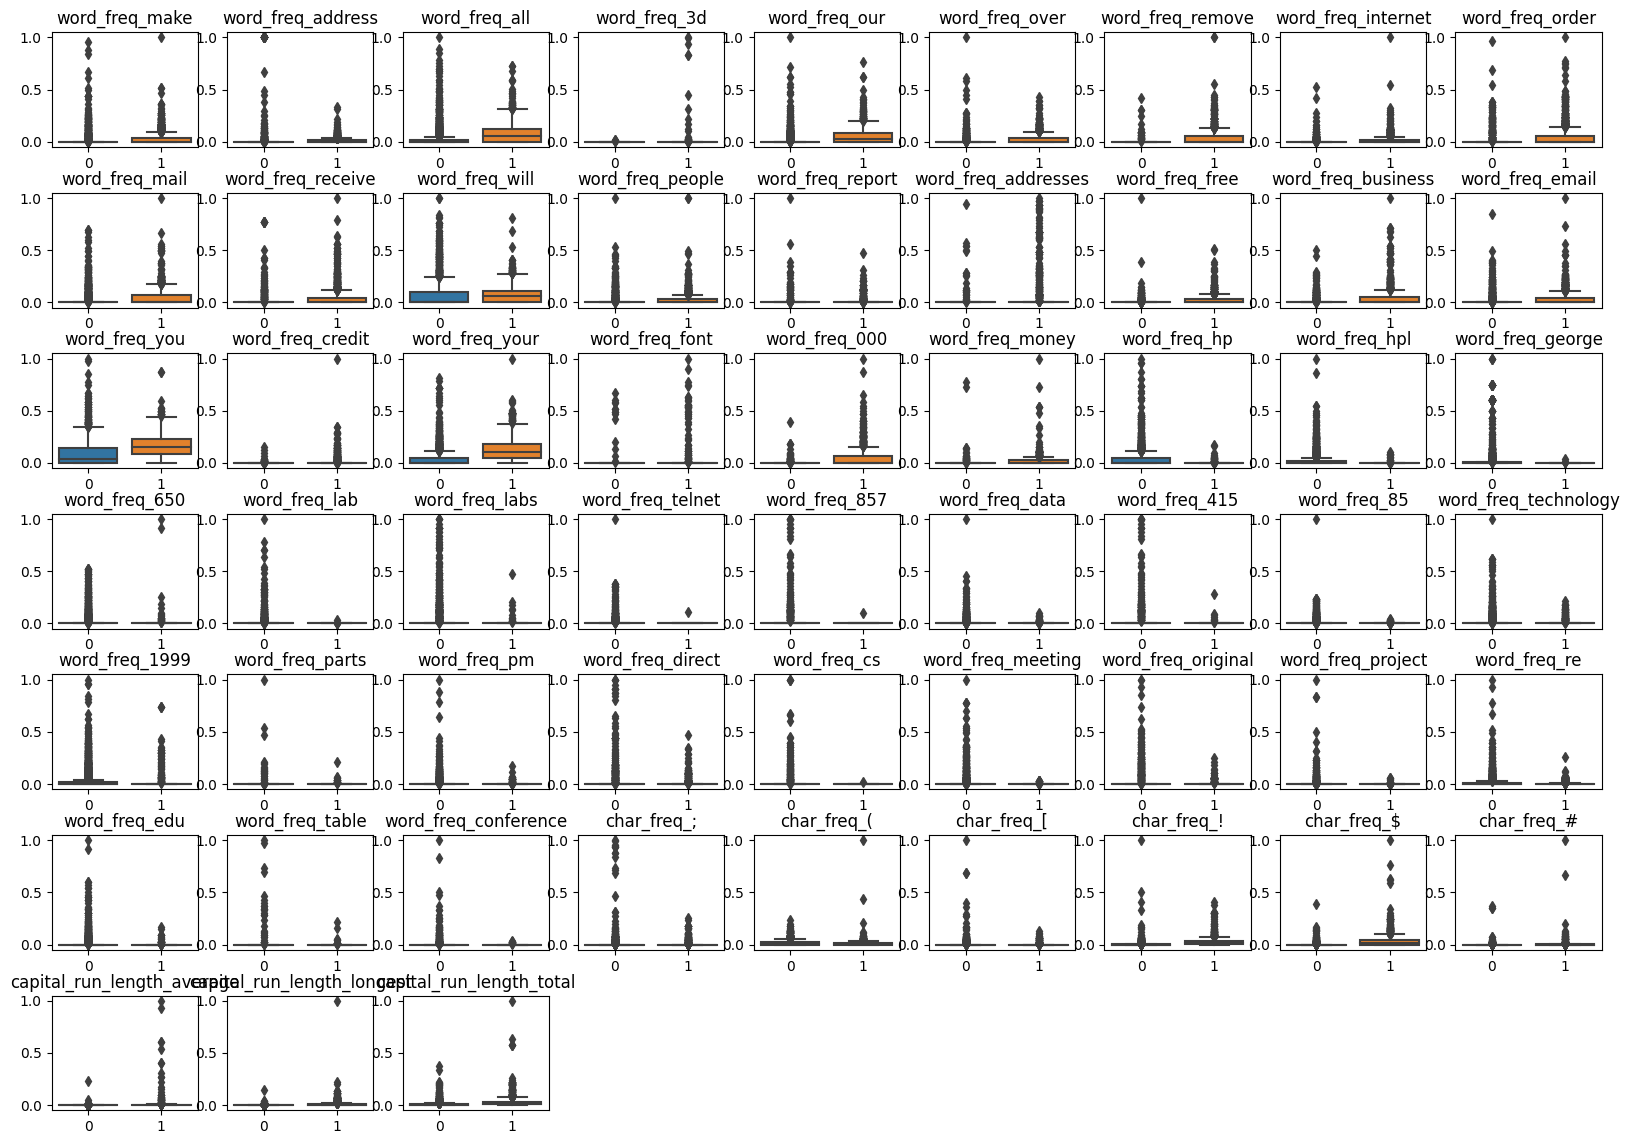

In [6]:
# 箱线图显示
# 对比不同类型的右键在每个特征变量上的数据分布情况
colname = spam.columns.values[:-1]

plt.figure(figsize=(20, 14))
for ii in range(len(colname)):
    plt.subplot(7, 9, ii+1)
    sns.boxplot(x=y_train, y=X_train_s[:, ii])
    plt.title(colname[ii])
    
plt.subplots_adjust(hspace=0.4)
plt.show()

## 搭建网络并可视化

In [7]:
# 全连接网络
class MLPclassifica(nn.Module):
    def __init__(self):
        super(MLPclassifica, self).__init__()
        
        # 定义第一个隐藏层
        self.hidden1 = nn.Sequential(
            nn.Linear(
                in_features=57,   # 第一个隐藏层的输入，数据的特征数量
                out_features=30,  # 第一个隐藏层的输出，神经元的数量
                bias=True,       # 默认会有偏置
            ),
            nn.ReLU(),
        )
        
        # 定义第二个隐藏层
        self.hidden2 = nn.Sequential(
            nn.Linear(
                in_features=30,
                out_features=10,
            ),
            nn.ReLU(),
        )
        
        # 分类层
        
        self.classifica = nn.Sequential(
            nn.Linear(
                in_features=10,
                out_features=2,
            ),
            nn.Sigmoid(),
        )
        
    # 定义网络的前向传播路径
    def forward(self, x):
        fc1 = self.hidden1(x)
        fc2 = self.hidden2(fc1)
        output = self.classifica(fc2)
        
        # 输出为两个隐藏层和输出层
        return fc1, fc2, output

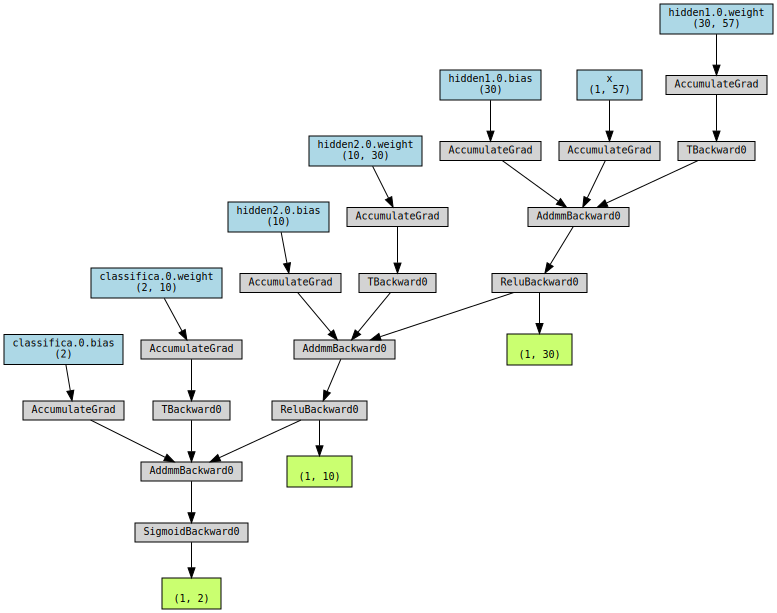

In [8]:
# 输出网络结构
mlpc = MLPclassifica()

# 使用make_dot可视化网络
x = torch.randn(1, 57).requires_grad_(True)
y = mlpc(x)
Mymlpcvis = make_dot(y, params=dict(list(mlpc.named_parameters())+[('x', x)]))
Mymlpcvis

## 使用未预处理的数据训练模型

In [9]:
# 将数据转化为张量
X_train_nots = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.int64))
X_test_nots = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.int64))

# 将训练集转化为张量后，使用TensorDataset将X和Y整理到一起
train_data_nots = Data.TensorDataset(X_train_nots, y_train_t)

# 定义一个数据加载器，将训练数据集进行批量处理
train_nots_loader = Data.DataLoader(
    dataset = train_data_nots,
    batch_size = 64,
    shuffle = True,
    num_workers = 8,
)

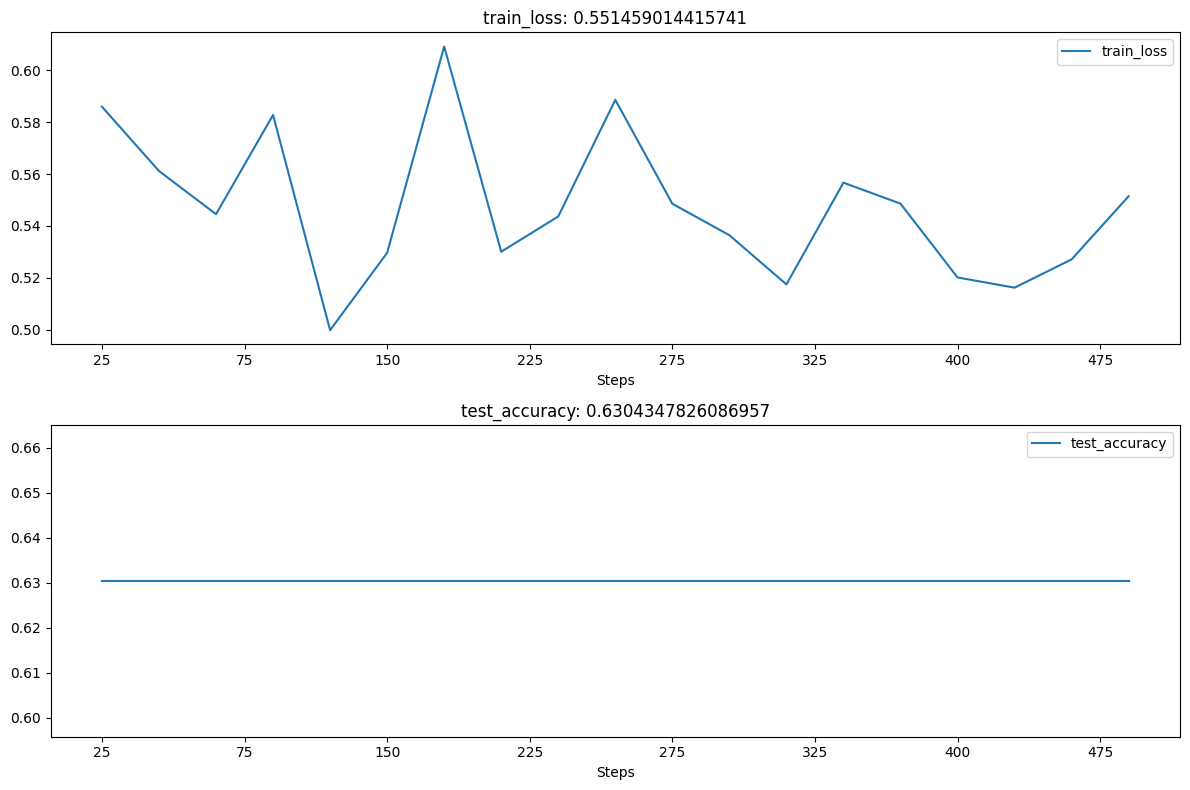

In [ ]:
# 定义优化器
optimizer = torch.optim.Adam(mlpc.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()   # 二分类损失函数

# 记录训练过程的指标
history1 = hl.History()

# 使用Canvas进行可视化
canvas1 = hl.Canvas()
print_step = 25

# 对模型进行迭代训练，对所有的数据训练epoch轮
for epoch in range(15):
    # 对训练数据的加载器进行迭代计算
    for step, (b_x ,b_y) in enumerate(train_nots_loader):
        # 计算每个batch的损失
        _, _, output = mlpc(b_x)
        train_loss = loss_func(output, b_y)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        niter = epoch * len(train_nots_loader) + step + 1
        
        # 计算经过print_step次迭代后的输出
        if niter % print_step == 0:
            _, _, output = mlpc(X_test_nots)
            _, pre_lab = torch.max(output, 1)
            test_accuracy = accuracy_score(y_test_t, pre_lab)
            
            # 为history添加epoch，损失和精度
            history1.log(niter, train_loss=train_loss, test_accuracy=test_accuracy)
            
            # 使用两个图可视化损失函数和精度
            with canvas1:
                canvas1.draw_plot(history1['train_loss'])
                canvas1.draw_plot(history1['test_accuracy'])

使用为标准化的数据集训练的模型并没有训练效果，即MLP分类器没有收敛。可能的原因如下：
- 数据没有经过标准化预处理，所有网络没有收敛
- 使用的训练数据样本太少，导致网络没有收敛
- 搭建的MLP网络使用的神经元太多或太少，所有网络没有收敛

## 使用预处理后的数据训练模型

In [11]:
# 将数据转化为张量
X_train_t = torch.from_numpy(X_train_s.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.int64))
X_test_t = torch.from_numpy(X_test_s.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.int64))

# 将训练集转化为张量后，使用TensorDataset将X和Y整理到一起
train_data = Data.TensorDataset(X_train_t, y_train_t)

# 定义一个数据加载器，将训练数据集进行批量处理
train_loader = Data.DataLoader(
    dataset = train_data,
    batch_size = 64,
    shuffle = True,
    num_workers = 1,
)

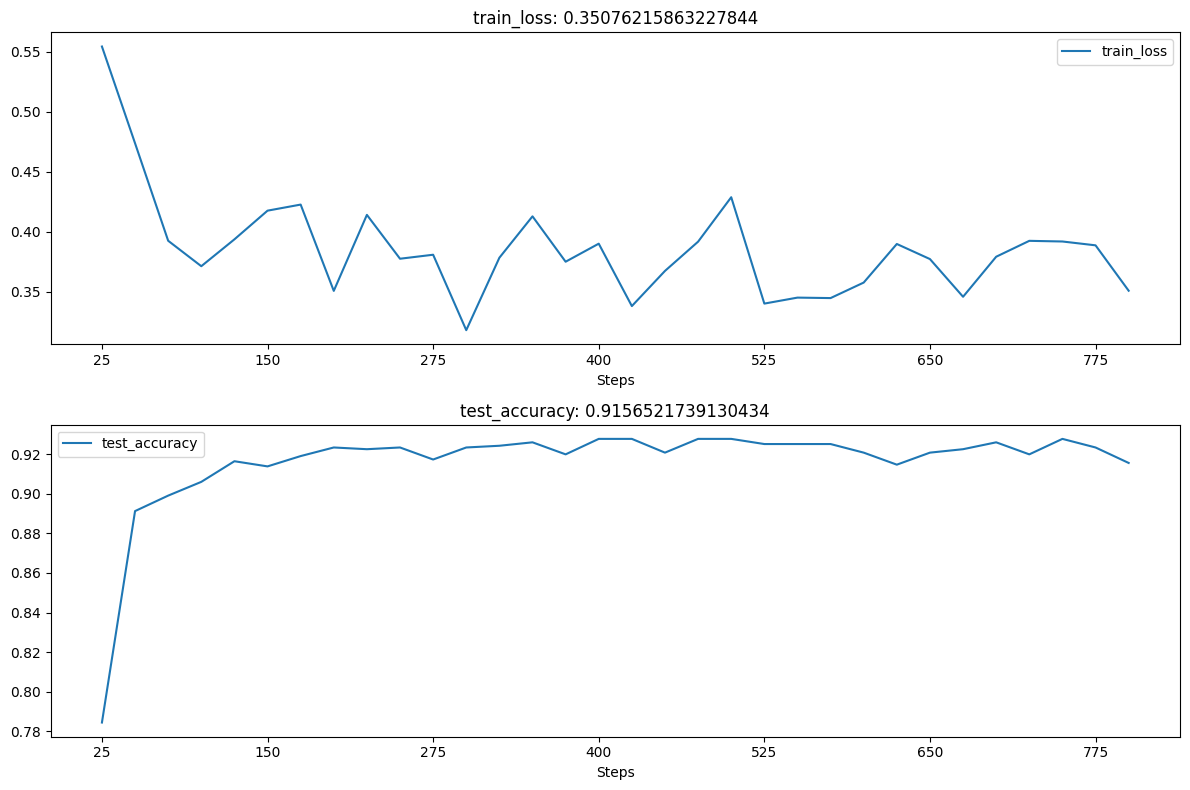

In [12]:
# 定义优化器
optimizer = torch.optim.Adam(mlpc.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()   # 二分类损失函数

# 记录训练过程的指标
history1 = hl.History()

# 使用Canvas进行可视化
canvas1 = hl.Canvas()
print_step = 25

# 对模型进行迭代训练，对所有的数据训练epoch轮
for epoch in range(15):
    # 对训练数据的加载器进行迭代计算
    for step, (b_x ,b_y) in enumerate(train_loader):
        # 计算每个batch的损失
        _, _, output = mlpc(b_x)
        train_loss = loss_func(output, b_y)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        niter = epoch * len(train_loader) + step + 1
        
        # 计算经过print_step次迭代后的输出
        if niter % print_step == 0:
            _, _, output = mlpc(X_test_t)
            _, pre_lab = torch.max(output, 1)
            test_accuracy = accuracy_score(y_test_t, pre_lab)
            
            # 为history添加epoch，损失和精度
            history1.log(niter, train_loss=train_loss, test_accuracy=test_accuracy)
            
            # 使用两个图可视化损失函数和精度
            with canvas1:
                canvas1.draw_plot(history1['train_loss'])
                canvas1.draw_plot(history1['test_accuracy'])

In [13]:
# 计算模型在测试集上的最终精度
_, _, output = mlpc(X_test_t)
_, pre_lab = torch.max(output, 1)
test_accuracy = accuracy_score(y_test_t, pre_lab)
print("test_accuracy:", test_accuracy)

test_accuracy: 0.9191304347826087


## 获取中间层的输出并可视化

### 使用中间层的输出

In [14]:
# 计算最终模型在测试集上的第二个隐藏层的输出
_, test_fc2, _ = mlpc(X_test_t)
print("test_fc2.shape:", test_fc2.shape)

test_fc2.shape: torch.Size([1150, 10])


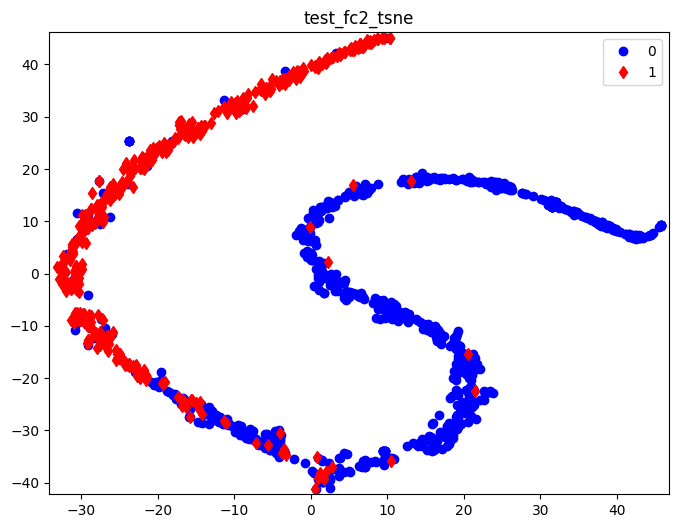

In [15]:
# 对输出进行降维并可视化
test_fc2_tsne = TSNE(n_components=2).fit_transform(test_fc2.data.numpy())

# 将特征进行可视化
plt.figure(figsize=(8, 6))

# 可视化前色湖之坐标系的取值范围
plt.xlim([min(test_fc2_tsne[:, 0]-1), max(test_fc2_tsne[:, 0]+1)])
plt.ylim([min(test_fc2_tsne[:, 1]-1), max(test_fc2_tsne[:, 1]+1)])
plt.plot(test_fc2_tsne[y_test==0, 0], test_fc2_tsne[y_test==0, 1], "bo", label="0")
plt.plot(test_fc2_tsne[y_test==1, 0], test_fc2_tsne[y_test==1, 1], "rd", label="1")

plt.legend()
plt.title("test_fc2_tsne")
plt.show()

### 使用钩子获取中间层的输出


In [16]:
# 定义一个辅助函数，来获取指定层名称的特征
activation = {} # 保存不同层的输出
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [17]:
# 全连接神经网络获取分类层的输出
mlpc.classifica.register_forward_hook(get_activation("classifica"))
_, _, _ = mlpc(X_test_t)
classifica = activation["classifica"].data.numpy()
print("classifica.shape:", classifica.shape)

classifica.shape: (1150, 2)


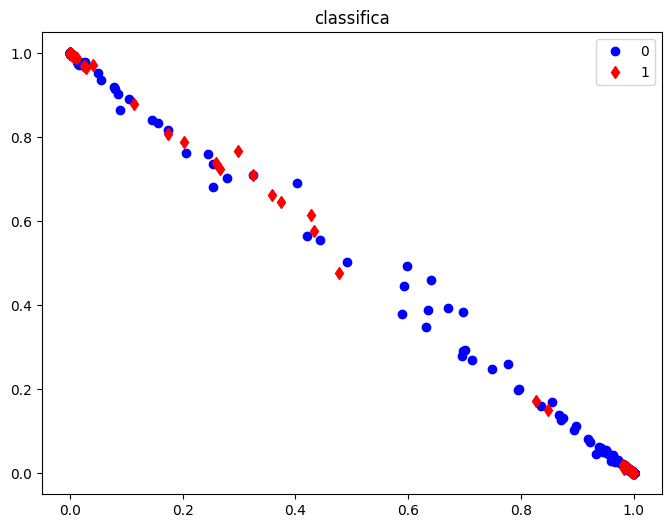

In [18]:
# 将特征进行可视化
plt.figure(figsize=(8, 6))

# 可视化每类的散点图
plt.plot(classifica[y_test==0, 0], classifica[y_test==0, 1], "bo", label="0")
plt.plot(classifica[y_test==1, 0], classifica[y_test==1, 1], "rd", label="1")

plt.legend()
plt.title("classifica")
plt.show()

# MLP回归模型

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import fetch_california_housing

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import torch.utils.data as Data

import matplotlib.pyplot as plt
import seaborn as sns

## 房价数据准备

In [2]:
# 导入数据
housdata = fetch_california_housing()

# 数据切分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(housdata.data, housdata.target, test_size=0.3, random_state=42)

# 数据标准化处理
scale = StandardScaler()
X_train_s = scale.fit_transform(X_train)
X_test_s = scale.transform(X_test)

# 将训练数据处理为数据表，方便探索数据情况
housdatadf = pd.DataFrame(data=X_train_s, columns=housdata.feature_names)
housdatadf['target'] = y_train

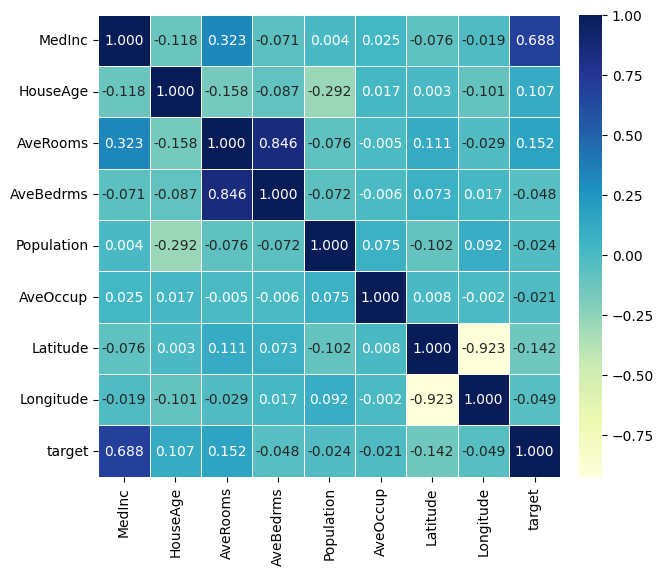

In [6]:
# 可视化数据的相关系数热力图
datacor = np.corrcoef(housdatadf.values, rowvar=0)   #计算变量之间的相关系数
datacor = pd.DataFrame(data=datacor, columns=housdatadf.columns, index=housdatadf.columns)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(datacor, square=True, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu", cbar_kws={"fraction":0.046, "pad":0.03})
plt.show()

从图像中可以发现和目标函数相关性最大的是MedInc（收入中位数）。而且AveRooms和AveBedrms两个变量之间的正相关性较强

In [7]:
# 将数据转化为张量
train_x_t = torch.from_numpy(X_train_s.astype(np.float32))
train_y_t = torch.from_numpy(y_train.astype(np.float32))
test_x_t = torch.from_numpy(X_test_s.astype(np.float32))
test_y_t = torch.from_numpy(y_test.astype(np.float32))

# 将训练数据处理为数据加载器
train_data = Data.TensorDataset(train_x_t, train_y_t)
test_data = Data.TensorDataset(test_x_t, test_y_t)
train_loader = Data.DataLoader(dataset=train_data, batch_size=64, shuffle=True, num_workers=1)

## 搭建网络预测房价

In [8]:
# 搭建全连接神经网络回归网络
class MLPregression(nn.Module):
    def __init__(self):
        super(MLPregression, self).__init__()
        
        # 定义第一个隐藏层
        self.hidden1 = nn.Linear(
            in_features=8,
            out_features=100,
            bias=True,
        )
        
        # 定义第二个隐藏层
        self.hidden2 = nn.Linear(
            in_features=100,
            out_features=100,
            bias=True,
        )
        
        # 定义第三个隐藏层
        self.hidden3 = nn.Linear(
            in_features=100,
            out_features=50,
            bias=True,
        )
        
        # 回归预测层
        self.predict = nn.Linear(
            in_features=50,
            out_features=1,
            bias=True,
        )
        
    # 定义网络的前向传播路径
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        output = self.predict(x)
        # 输出一个一维向量
        return output[:, 0]

In [9]:
# 输出网络结构
mlpreg = MLPregression()
print(mlpreg)

MLPregression(
  (hidden1): Linear(in_features=8, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=50, bias=True)
  (predict): Linear(in_features=50, out_features=1, bias=True)
)


In [10]:
# 定义优化器
optimizer = torch.optim.SGD(mlpreg.parameters(), lr=0.01)
loss_func = nn.MSELoss()  # 均方根误差损失函数
train_loss_all = []

# 对模型进行迭代训练，对所有的数据训练epoch轮
for epoch in range(30):
    train_loss = 0
    train_num = 0
    
    # 对训练数据的加载器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_loader):
        output = mlpreg(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * b_x.size(0)
        train_num += b_x.size(0)
        
    train_loss_all.append(train_loss / train_num)

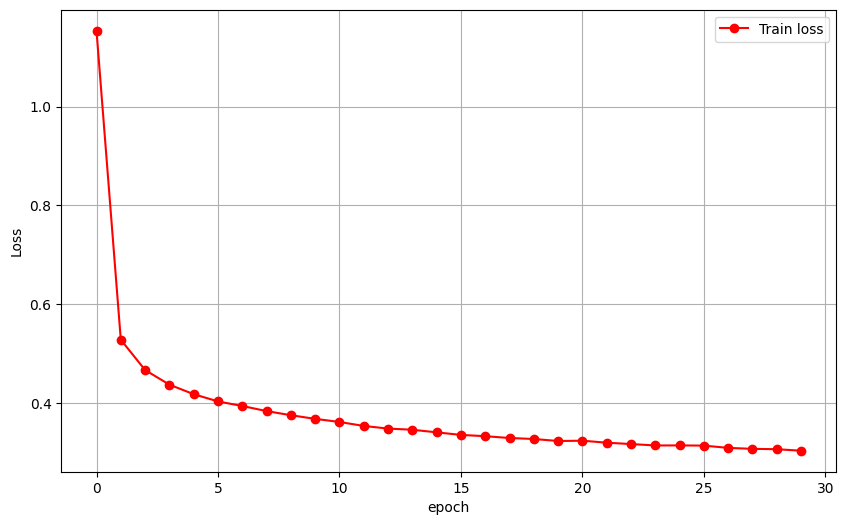

In [12]:
# 可视化损失函数的变化情况
plt.figure(figsize=(10, 6))
plt.plot(train_loss_all, "ro-", label="Train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

In [14]:
#  对测试集进行预测
pre_y = mlpreg(test_x_t)
pre_y = pre_y.data.numpy()
mae = mean_absolute_error(y_test, pre_y)
print("在测试集上的绝对值误差为：", mae)

在测试集上的绝对值误差为： 0.3848682918578432


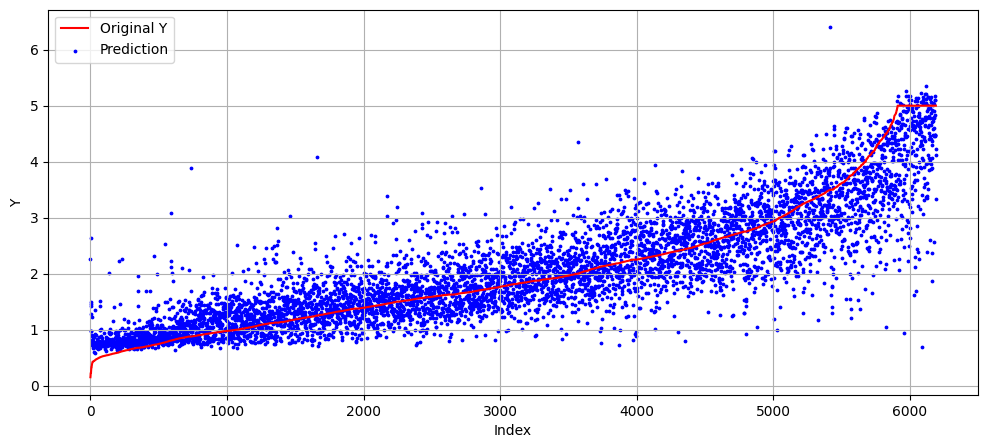

In [15]:
# 可视化在测试集上真实值和预测值的差异
index = np.argsort(y_test)
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(y_test)), y_test[index], "r", label="Original Y")
plt.scatter(np.arange(len(pre_y)), pre_y[index], s=3, c="b", label="Prediction")
plt.legend(loc="upper left")
plt.grid()
plt.xlabel("Index")
plt.ylabel("Y")
plt.show()